# Experiments

In [141]:
import os
import pickle as pkl
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
from skimage.color import rgb2ycbcr

from skimage.transform import resize
# change plt style to dark
plt.style.use('dark_background')
# make font size bigger
plt.rcParams.update({'font.size': 22})

## Plotting the dictionary

In [4]:
# addr for dictionaries
addr = "../data/dicts/"

dictonaries = {}
for dir in os.listdir(addr):
    if dir.endswith(".pkl"):
        dictonaries[dir] = pkl.load(open(addr + dir, "rb"))


In [9]:
for key, value in dictonaries.items():
    print(key, value.shape)

    # plot dictionary patches
    # Each dictionary is (x^2, 2048), create 2048 image patches where each image width is x
    # make a big plot of all the patches and save it
    x, y = value.shape

    patch_edge = int((x)**0.5)

    rows = int(y**0.5)+1
    cols = int(y**0.5)+1

    fig, ax = plt.subplots(rows, cols, figsize=(cols, rows))

    # set black background
    fig.patch.set_facecolor('white')

    # axis off
    for a in ax.flatten():
        a.axis('off')

    # set large spaces between patches
    plt.subplots_adjust(wspace=.1, hspace=.1)

    i = 0
    while(i < y):
        patch_x = i % cols
        patch_y = i // cols

        patch = value[:, i]

        # normalize patch
        patch = (patch - patch.min()) / (patch.max() - patch.min())

        # reshape patch
        patch = patch.reshape(patch_edge, patch_edge, order='F')

        # plot patch
        ax[patch_y, patch_x].imshow(patch, cmap='gray')


        i += 1

    # set plot title
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.suptitle(f'Dictionary: {patch_edge}x{patch_edge} patch, {y} Atoms', fontsize=54, color='black')
    plt.savefig(f"../data/dicts/viz/{'-'.join(key.split('.')[:-1])}.png")
    plt.close()





Dl_2048_US3_L0.1_PS3.pkl (36, 2048)
Dl_2048_US3_L0.1_PS5.pkl (100, 2048)
Dh_2048_US3_L0.1_PS3.pkl (9, 2048)
Dh_2048_US3_L0.1_PS5.pkl (25, 2048)


## Feature Extraction

In [2]:
def extract_lr_feat(img_lr):
    h, w = img_lr.shape
    img_lr_feat = np.zeros((h, w, 4))

    # First order gradient filters
    hf1 = [[-1, 0, 1], ] * 3
    vf1 = np.transpose(hf1)

    img_lr_feat[:, :, 0] = convolve2d(img_lr, hf1, 'same')
    img_lr_feat[:, :, 1] = convolve2d(img_lr, vf1, 'same')

    # Second order gradient filters
    hf2 = [[1, 0, -2, 0, 1], ] * 3
    vf2 = np.transpose(hf2)

    img_lr_feat[:, :, 2] = convolve2d(img_lr, hf2, 'same')
    img_lr_feat[:, :, 3] = convolve2d(img_lr, vf2, 'same')

    return img_lr_feat



In [6]:
# Loading a lr and hr image
lr_addr = "../data/val_lr/"
hr_addr = "../data/val_hr/"

# sampling random one image
lr_img_name = random.choice(os.listdir(lr_addr))
hr_img_name = lr_img_name 

lr_img = Image.open(lr_addr + lr_img_name)
hr_img = Image.open(hr_addr + hr_img_name)

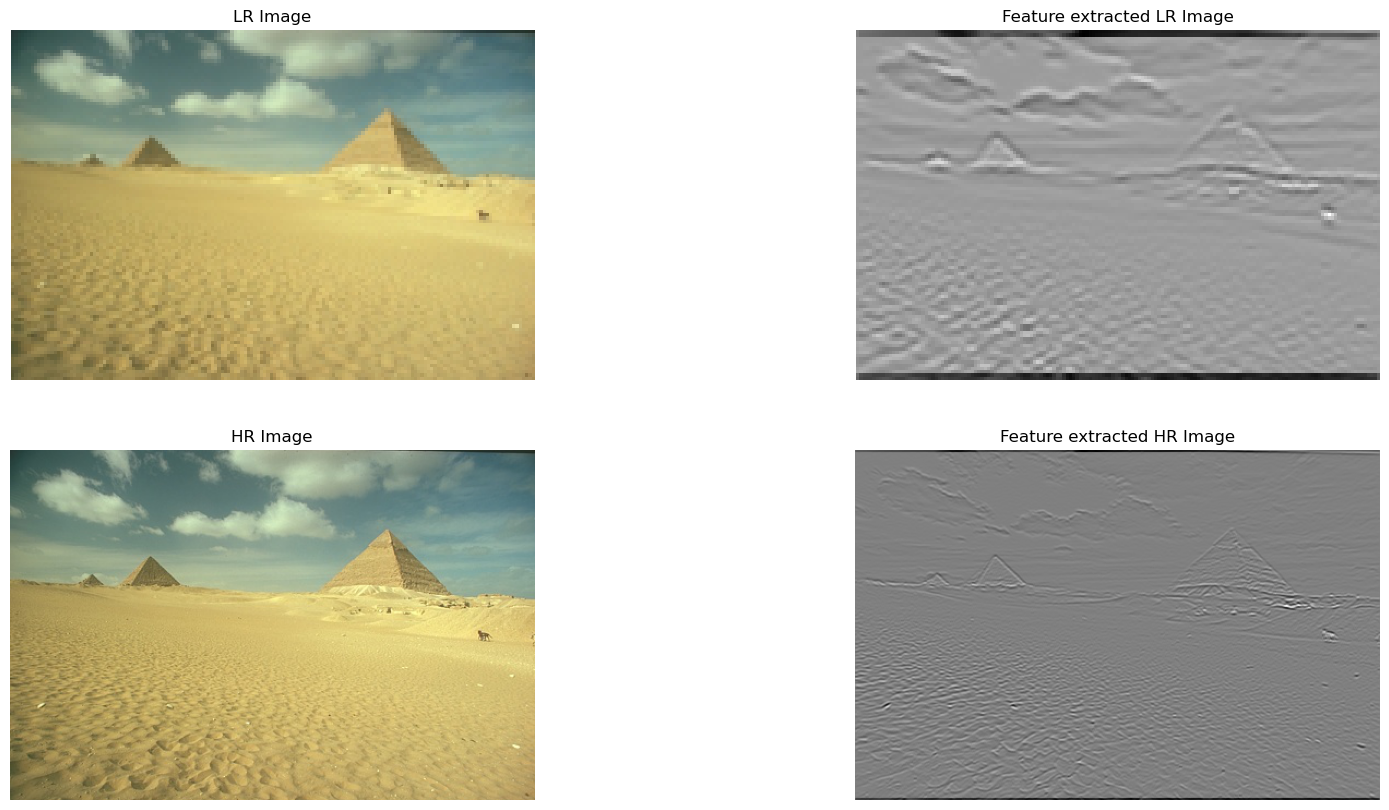

In [39]:
lr_img_y = rgb2ycbcr(np.array(lr_img))[:, :, 0]
hr_img_y = rgb2ycbcr(np.array(hr_img))[:, :, 0]

lr_img_y_feat = extract_lr_feat(lr_img_y)
hr_img_y_feat = extract_lr_feat(hr_img_y)

# normalize images
lr_img_y_feat = (lr_img_y_feat - lr_img_y_feat.min()) / (lr_img_y_feat.max() - lr_img_y_feat.min())
hr_img_y_feat = (hr_img_y_feat - hr_img_y_feat.min()) / (hr_img_y_feat.max() - hr_img_y_feat.min())

lr_img_y_feat = (lr_img_y_feat * 255).astype(np.uint8)
hr_img_y_feat = (hr_img_y_feat * 255).astype(np.uint8)

# plot lr and hr images
fig, ax = plt.subplots(2,2, figsize=(20, 10))

for a in ax.flatten():
    a.axis('off')

ax[0,0].imshow(lr_img)
ax[0,0].set_title("LR Image")
ax[1,0].imshow(hr_img)
ax[1,0].set_title("HR Image")

ax[0,1].imshow(lr_img_y_feat[:,:,3], cmap='gray')
ax[0,1].set_title("Feature extracted LR Image")
ax[1,1].imshow(hr_img_y_feat[:,:,3], cmap='gray')
ax[1,1].set_title("Feature extracted HR Image")
plt.show()

## Comparing given code result with exp1 (added c(X - X0)) 

In [155]:
import skimage.metrics as sm
import skimage.color as sc


# addr = "../data/results/2048_US3_L0.1_PS3_295087"
# true_addr = addr + "/3HR.png"
# given_addr = addr + "/2SR.png"
# exp1_addr = "../data/results/2048_US3_L0.1_PS3exp1_295087/2SR.png"

hr = "../data/results/512_US3_L0.1_PS5_42012/3HR.png"
sr = "../data/results/512_US3_L0.1_PS5_42012/2SR.png"
lr = "../data/results/512_US3_L0.1_PS5_42012/LR.png"
bilateral = "../data/results/512_US3_L0.1_PS5bilateral_42012/2SR.png"
recon = "../data/results/512_US3_L0.1_PS5recon_42012/2SR.png"
cnn = "../data/results/cnn/42012_new.png"


hr = Image.open(hr)
sr = Image.open(sr)
lr = Image.open(lr)
bilateral = Image.open(bilateral)
recon = Image.open(recon)
cnn = Image.open(cnn).convert('RGB')
bicubic = lr.resize(hr.size, Image.BICUBIC)


# true_img_y = sc.rgb2ycbcr(np.array(true_img))[:, :, 0]
# given_img_y = sc.rgb2ycbcr(np.array(given_img))[:, :, 0]
# exp1_img_y = sc.rgb2ycbcr(np.array(exp1_img))[:, :, 0]

hr_y = sc.rgb2ycbcr(np.array(hr))[:, :, 0]
sr_y = sc.rgb2ycbcr(np.array(sr))[:, :, 0]
bicubic_y = sc.rgb2ycbcr(np.array(bicubic))[:, :, 0]
bilateral_y = sc.rgb2ycbcr(np.array(bilateral))[:, :, 0]
recon_y = sc.rgb2ycbcr(np.array(recon))[:, :, 0]
cnn_y = sc.rgb2ycbcr(np.array(cnn))[:, :, 0]

cnn_y_mask = (cnn_y == np.max(cnn_y))

rows = np.any(~cnn_y_mask, axis=1)
columns = np.any(~cnn_y_mask, axis=0)

cnn_y = cnn_y[rows][:, columns]
# resize cnn_y to hr_y using skimage
cnn_y = resize(cnn_y, hr_y.shape, anti_aliasing=True)

# given_imgmax = given_img_y.max()
# given_imgmin = given_img_y.min()

# exp1_imgmax = exp1_img_y.max()
# exp1_imgmin = exp1_img_y.min()

# print(f"Given Image Max: {given_imgmax}, Min: {given_imgmin}"
#       f"Exp1 Image Max: {exp1_imgmax}, Min: {exp1_imgmin}")

# t_g_ssim = sm.structural_similarity(true_img_y, given_img_y, data_range=given_img_y.max() - given_img_y.min())
# t_e_ssim = sm.structural_similarity(true_img_y, exp1_img_y, data_range=exp1_img_y.max() - exp1_img_y.min())
# g_e_ssim = sm.structural_similarity(given_img_y, exp1_img_y, data_range=exp1_img_y.max() - exp1_img_y.min())

# print(f"True vs Given SSIM: {t_g_ssim}")
# print(f"True vs Exp1 SSIM: {t_e_ssim}")
# print(f"Given vs Exp1 SSIM: {g_e_ssim}")

t_lr_rmse = sm.mean_squared_error(hr_y, bicubic_y)
t_sr_rmse = sm.mean_squared_error(hr_y, sr_y)
t_recon_rmse = sm.mean_squared_error(hr_y, recon_y)
t_bilateral_rmse = sm.mean_squared_error(hr_y, bilateral_y)
t_cnn_rmse = sm.mean_squared_error(hr_y, cnn_y)

t_lr_ssim = sm.structural_similarity(hr_y, bicubic_y, data_range=bicubic_y.max() - bicubic_y.min())
t_sr_ssim = sm.structural_similarity(hr_y, sr_y, data_range=sr_y.max() - sr_y.min())
t_recon_ssim = sm.structural_similarity(hr_y, recon_y, data_range=recon_y.max() - recon_y.min())
t_bilateral_ssim = sm.structural_similarity(hr_y, bilateral_y, data_range=bilateral_y.max() - bilateral_y.min())
t_cnn_ssim = sm.structural_similarity(hr_y, cnn_y, data_range=cnn_y.max() - cnn_y.min())

t_lr_psnr = sm.peak_signal_noise_ratio(hr_y, bicubic_y, data_range=bicubic_y.max() - bicubic_y.min())
t_sr_psnr = sm.peak_signal_noise_ratio(hr_y, sr_y, data_range=sr_y.max() - sr_y.min())
t_recon_psnr = sm.peak_signal_noise_ratio(hr_y, recon_y, data_range=recon_y.max() - recon_y.min())
t_bilateral_psnr = sm.peak_signal_noise_ratio(hr_y, bilateral_y, data_range=bilateral_y.max() - bilateral_y.min())
t_cnn_psnr = sm.peak_signal_noise_ratio(hr_y, cnn_y, data_range=cnn_y.max() - cnn_y.min())

print(f"HR vs Bicubic RMSE: {t_lr_rmse}")
print(f"HR vs SR RMSE: {t_sr_rmse}")
print(f"HR vs Recon RMSE: {t_recon_rmse}")
print(f"HR vs Bilateral RMSE: {t_bilateral_rmse}")
print(f"HR vs CNN RMSE: {t_cnn_rmse}")
print("---------------------------------")
print(f"HR vs Bicubic SSIM: {t_lr_ssim}")
print(f"HR vs SR SSIM: {t_sr_ssim}")
print(f"HR vs Recon SSIM: {t_recon_ssim}")
print(f"HR vs Bilateral SSIM: {t_bilateral_ssim}")
print(f"HR vs CNN SSIM: {t_cnn_ssim}")
print("---------------------------------")
print(f"HR vs Bicubic PSNR: {t_lr_psnr}")
print(f"HR vs SR PSNR: {t_sr_psnr}")
print(f"HR vs Recon PSNR: {t_recon_psnr}")
print(f"HR vs Bilateral PSNR: {t_bilateral_psnr}")
print(f"HR vs CNN PSNR: {t_cnn_psnr}")

HR vs Bicubic RMSE: 73.42548369557917
HR vs SR RMSE: 67.6248801604825
HR vs Recon RMSE: 73.89465188025936
HR vs Bilateral RMSE: 84.20354850763754
HR vs CNN RMSE: 77.03007215542685
---------------------------------
HR vs Bicubic SSIM: 0.8092208069680087
HR vs SR SSIM: 0.8432393232780955
HR vs Recon SSIM: 0.8382285332857504
HR vs Bilateral SSIM: 0.7833684318793923
HR vs CNN SSIM: 0.8242087810025046
---------------------------------
HR vs Bicubic PSNR: 27.240599114393298
HR vs SR PSNR: 28.366542150941058
HR vs Recon PSNR: 27.942823640772822
HR vs Bilateral PSNR: 26.361414731358263
HR vs CNN PSNR: 26.844045409016687


In [146]:
# ssim with 2 decimal points
f"ssim: {t_cnn_ssim:.2f}"


'ssim: 0.77'

Text(0.5, 1.0, 'Learnt Feature Maps')

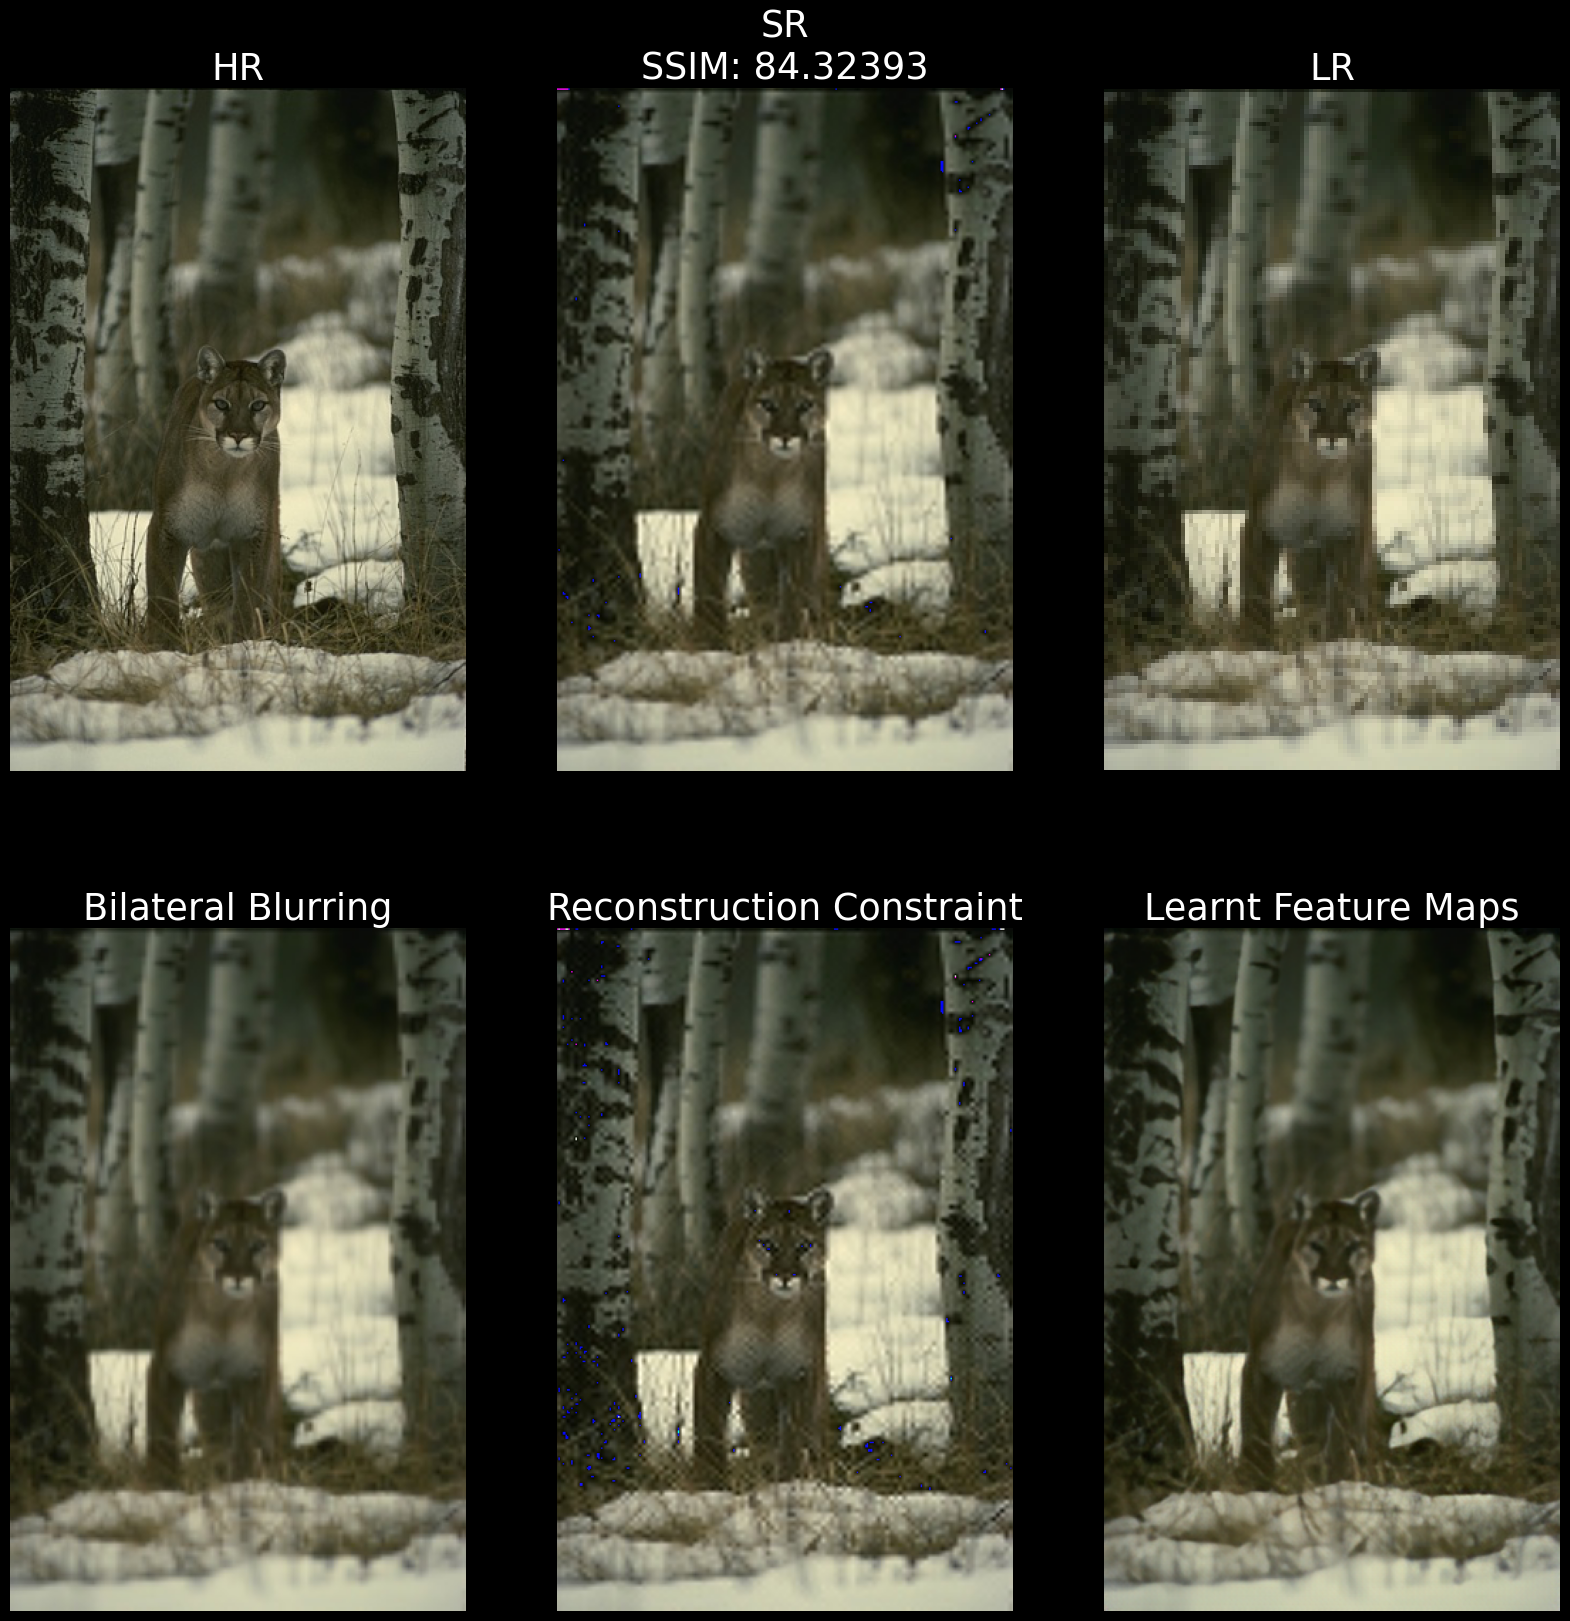

In [150]:
# plot 3x3 images

fig, ax = plt.subplots(2, 3, figsize=(20, 20))

# don't show axis numbers
for a in ax.flatten():
    # don't turn off axis
    a.axis('off')

ax[0, 0].imshow(hr, cmap='gray')
ax[0, 0].set_title("HR")
ax[0, 1].imshow(sr, cmap='gray')
ax[0, 1].set_title(f"SR\nSSIM: {100 * t_sr_ssim:.5f}")
ax[0, 2].imshow(lr, cmap='gray')
ax[0, 2].set_title("LR")
ax[1, 0].imshow(bilateral, cmap='gray')
ax[1, 0].set_title("Bilateral Blurring")
ax[1, 1].imshow(recon, cmap='gray')
ax[1, 1].set_title("Reconstruction Constraint")
ax[1, 2].imshow(np.array(cnn)[rows][:, columns], cmap='gray')
ax[1, 2].set_title("Learnt Feature Maps")

# Place metrics under specific images
# ax[1, 0].set_xlabel(f"Recon Metric: {t_recon_ssim}", labelpad=10, fontsize=12)  # Adjust the metric value as needed
# ax[1, 1].set_xlabel(f"Bilateral Metric: {t_bilateral_ssim}", labelpad=10, fontsize=12)  # Adjust the metric value as needed
# ax[1, 2].set_xlabel(f"CNN Metric: {t_cnn_ssim}", labelpad=10, fontsize=12)  # Adjust the metric value as needed

# Show the plot
# plt.tight_layout()
# plt.show()


(-0.5, 513.5, 769.5, -0.5)

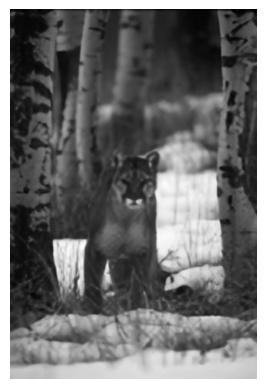

In [117]:
# remove white border from cnn image
# cnn image has different scaling than hr image
# find white border and crop it
# create a mask for white border

# single channel image with white border
cnn_y_arr = np.array(cnn_y)
cnn_y_mask = (cnn_y_arr == np.max(cnn_y_arr))

rows = np.any(~cnn_y_mask, axis=1)
columns = np.any(~cnn_y_mask, axis=0)

cropped_cnn_y = cnn_y[rows][:, columns]

plt.imshow(cropped_cnn_y, cmap='gray')
plt.axis('off')


In [109]:
# (cnn_y_arr <= 235).sum()
cropped_cnn_y.shape

(770, 514)

## Making collages

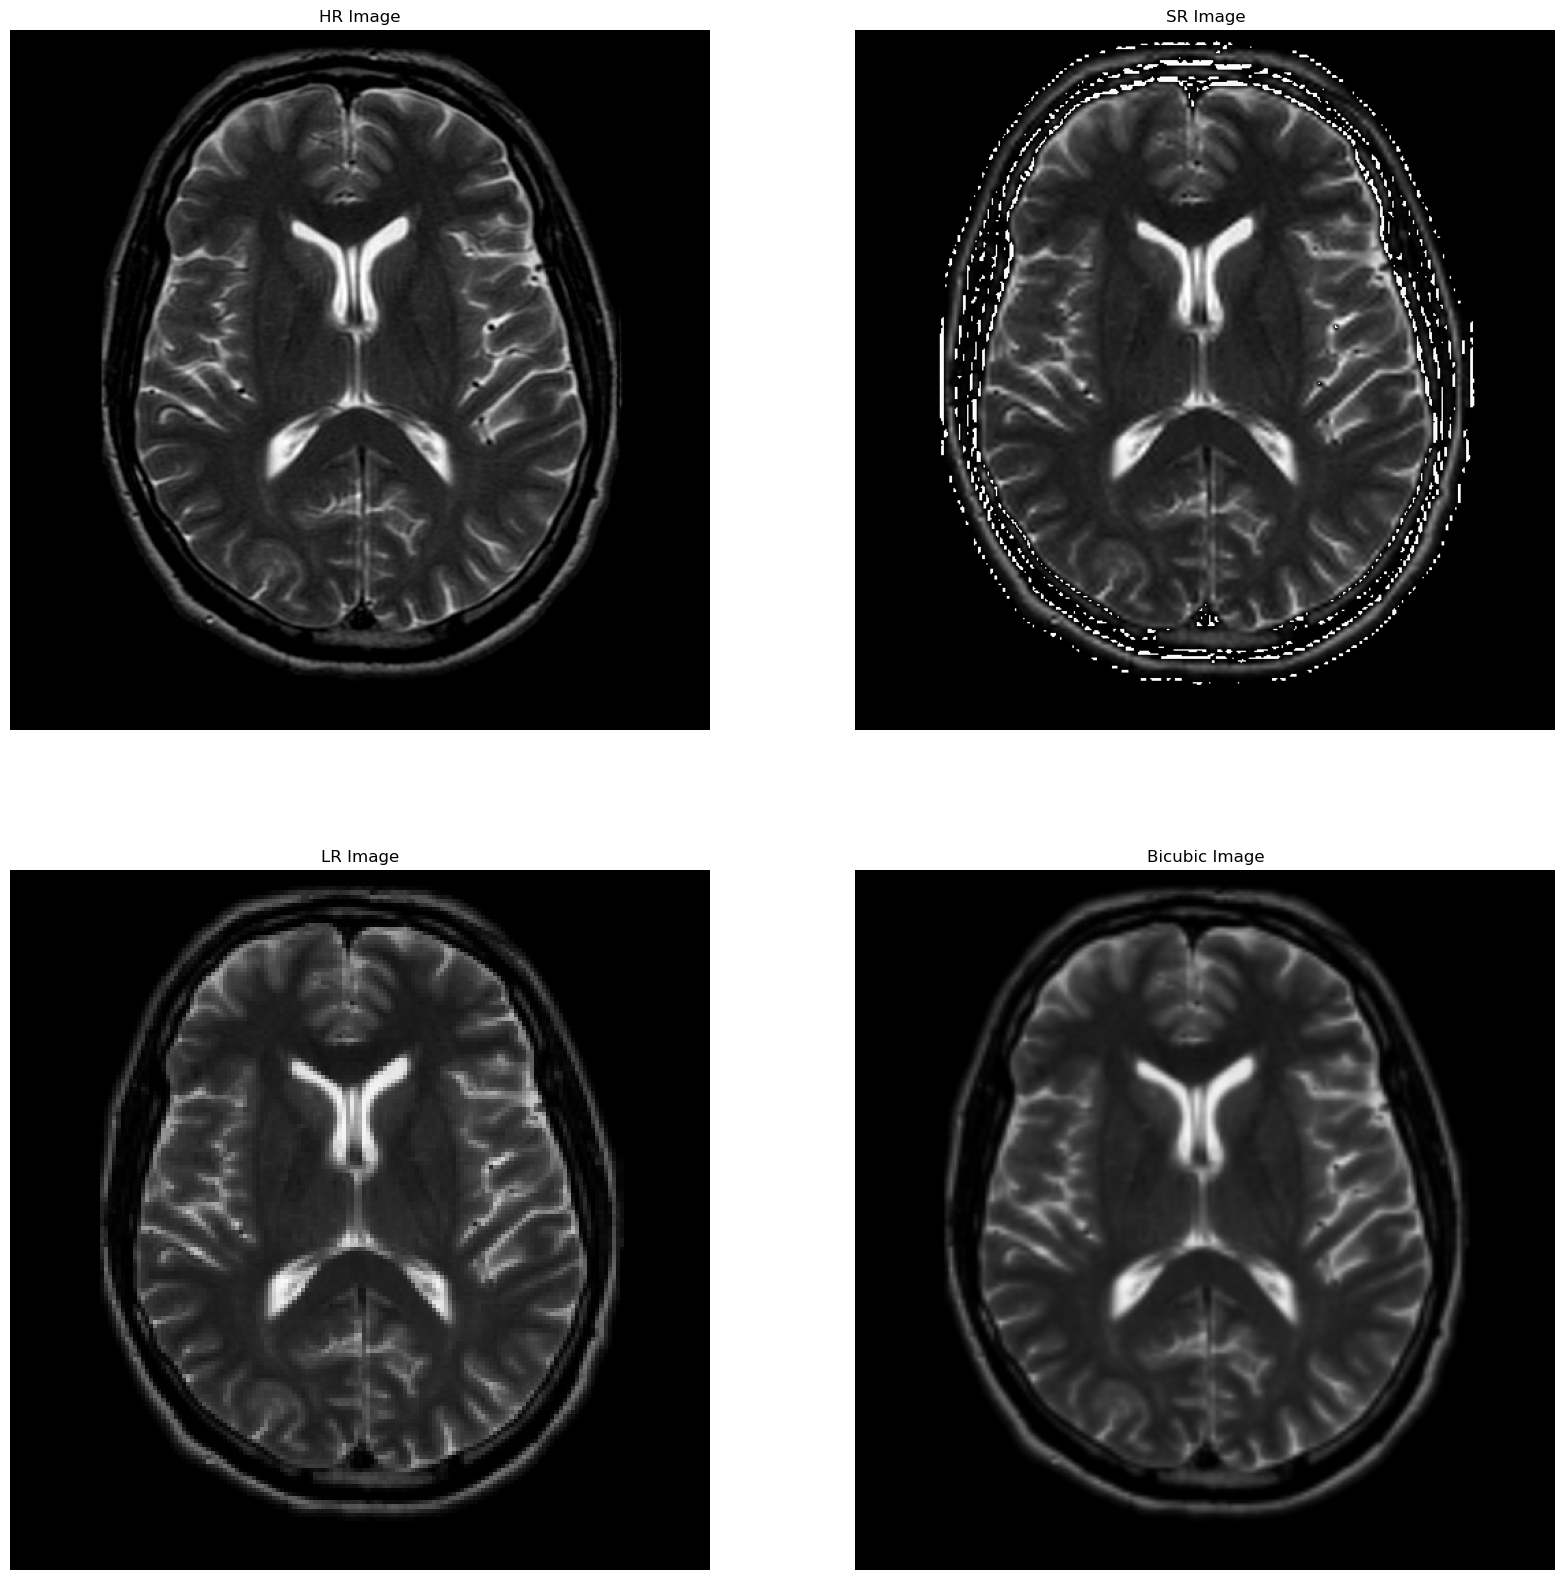

In [6]:
results_dir = os.listdir("../data/results/")
directories = [d for d in results_dir if 'brain' in d]


d = "../data/results/" + directories[0]

hr = Image.open(d + "/3HR.png")
lr = Image.open(d + "/LR.png")
sr = Image.open(d + "/2SR.png")
bicubic = Image.open(d + "/1bicubic.png")

fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for a in ax.flatten():
    a.axis('off')

ax[0, 0].imshow(hr)
ax[0, 0].set_title("HR Image")

ax[1, 0].imshow(lr)
ax[1, 0].set_title("LR Image")

ax[0, 1].imshow(sr)
ax[0, 1].set_title("SR Image")

ax[1, 1].imshow(bicubic)
ax[1, 1].set_title("Bicubic Image")

plt.savefig(d + "/viz.png")


## ResNet18 Layers and Visualization

In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

def extract_cnn_features(img_path):
    # Load a pretrained ResNet model
    model = models.resnet18(pretrained=True)
    # Remove the final fully connected layer to use the model as a feature extractor
    model = torch.nn.Sequential(*(list(model.children())[:-1]))
    model.eval()  # Set the model to evaluation mode

    # Define the preprocessing transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the image, apply the transformation
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

    # Use the model to extract features
    with torch.no_grad():  # Ensure no gradients are computed to save memory
        features = model(img_tensor)

    # Flatten the features to fit the expected output format
    features = features.view(features.size(0), -1)
    return features.numpy()  # Convert to NumPy array for further processing if necessary

# Example usage:
# features = extract_cnn_features('path_to_your_image.jpg')


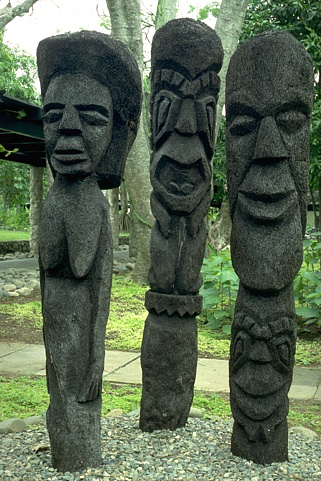

In [9]:
img_name = "101085.jpg"
hr = Image.open("../data/val_hr/" + img_name)
lr = Image.open("../data/val_lr/" + img_name)


In [ ]:
# print resnet18 layer names
model = models.resnet18(pretrained=True)
for name, module in model.named_children():
    print(name)
    

: 

In [15]:
models.resnet18(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

def visualize_feature_maps(img_path, layer_name='layer1'):
    # Load a pretrained ResNet model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.eval()  # Set the model to evaluation mode

    # Hook to grab the feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Attach the hook to the desired layer
    getattr(model, layer_name).register_forward_hook(get_activation(layer_name))

    # Define the preprocessing transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess the image
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

    # Pass the image through the model
    with torch.no_grad():
        _ = model(img_tensor)

    # Get the feature maps
    feature_maps = activation[layer_name].squeeze(0)

    n = int(feature_maps.size(0)**0.5 + 1)

    # Plot the image and the feature maps
    fig, axes = plt.subplots(n, n, figsize=(20, 20))
    # figure heading
    fig.suptitle(f'Feature Maps from {layer_name}', fontsize=27)
    ax = axes.ravel()
    for idx in range(n*n):
        ax[idx].axis('off')

    # Plot the original image
    img = Image.open(img_path)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    print(f'feature shape: {feature_maps.shape}')

    # Plot each feature map
    for i, fmap in enumerate(feature_maps):
        ax[i + 1].imshow(fmap.cpu().numpy(), cmap='gray')
        ax[i + 1].set_title(f'Feature Map {i + 1}')
    
    
    if not os.path.exists("../data/feature_maps/"):
        os.makedirs("../data/feature_maps/")

    plt.savefig(f"../data/feature_maps/42012_{layer_name}.png")


In [75]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torch.nn.functional import interpolate

def extract_cnn_features(img_path):
    # Load a pretrained ResNet model with the best available pretrained weights
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    # Extract only the first layer
    first_layer = torch.nn.Sequential(*(list(model.children())[:4]))  # Include until the first pooling to preserve spatial dimensions
    model = torch.nn.Sequential(first_layer)
    model.eval()  # Set the model to evaluation mode

    # Define the preprocessing transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std)
    ])

    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')  # Ensure image is RGB
    img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

    # Get the original image size (height, width)
    original_size = img.size[::-1]

    # Pass the image through the model
    with torch.no_grad():
        features = model(img_tensor)
    print(features.shape)
    # Resize feature maps to the size of the original image
    features_resized = interpolate(features, size=original_size, mode='bilinear', align_corners=False)

    # Convert to numpy array for further processing if necessary
    features_np = features_resized.squeeze(0).permute(1, 2, 0).numpy()

    return features_np




In [74]:
list(resnet18().children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [28]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import os

plt.style.use('ggplot')

def visualize_feature_maps(img_path, layer_name='layer1'):
    # Load a pretrained ResNet model in evaluation mode
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.eval()

    # Prepare a hook to capture the feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    getattr(model, layer_name).register_forward_hook(get_activation(layer_name))

    # Image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        img = Image.open(img_path)
    except IOError:
        print("Error: File does not appear to exist.")
        return

    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Forward pass to extract features
    with torch.no_grad():
        _ = model(img_tensor)

    feature_maps = activation[layer_name].squeeze(0)
    num_maps = feature_maps.size(0)
    n = int(np.sqrt(num_maps)) + 1  # Determine grid size

    # Dynamically adjust figure size based on number of feature maps
    fig_size = max(15, n * 2.5)  # Adjust base figure size here
    fig, axes = plt.subplots(n, n, figsize=(fig_size, fig_size))
    fig.suptitle(f'Feature Maps from {layer_name}', fontsize=27)

    # Display the original image
    axes = axes.ravel()

    for ax in axes:
        ax.axis('off')

    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=15)


    print(f'Feature shape: {feature_maps.shape}')

    # Display each feature map
    for i, fmap in enumerate(feature_maps):
        if i + 1 < len(axes):  # Check if there are more axes than feature maps
            axes[i + 1].imshow(fmap.cpu().numpy(), cmap='gray', norm=Normalize())
            axes[i + 1].set_title(f'Feature Map {i + 1}', fontsize=10)

    # Save the feature maps
    save_path = "../data/feature_maps"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.savefig(os.path.join(save_path, f"42012_{layer_name}.png"))


In [70]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import os

plt.style.use('ggplot')
# font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

def visualize_feature_maps(img_path, layer_name='layer1'):
    # Load a pretrained ResNet model in evaluation mode
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.eval()

    # Prepare a hook to capture the feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    getattr(model, layer_name).register_forward_hook(get_activation(layer_name))

    # Image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        img = Image.open(img_path)
    except IOError:
        print("Error: File does not appear to exist.")
        return

    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Forward pass to extract features
    with torch.no_grad():
        _ = model(img_tensor)

    feature_maps = activation[layer_name].squeeze(0)
    num_maps = feature_maps.size(0)

    # Set figure and subplot grid
    fig = plt.figure(figsize=(20, 24))
    original_ax = plt.subplot2grid((9, 8), (0, 0), colspan=8, rowspan=1, fig=fig)
    original_ax.imshow(img)
    original_ax.set_title('Original Image', fontsize=15)
    original_ax.axis('off')

    # Adjust super title position dynamically
    suptitle = fig.suptitle(f'Feature Maps from ResNet18 {layer_name}', fontsize=27)
    suptitle.set_y(0.92)  # Adjust this value as needed to centralize the suptitle

    # Display each feature map in an 8x8 grid
    for i in range(64):
        ax = plt.subplot2grid((9, 8), (1 + i // 8, i % 8), fig=fig)
        if i < num_maps:
            ax.imshow(feature_maps[i].cpu().numpy(), cmap='gray', norm=Normalize())
            ax.set_title(f'Feature Map {i + 1}', fontsize=10)
        ax.axis('off')

    # Save the feature maps
    save_path = "../data/feature_maps"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.savefig(os.path.join(save_path, f"299086_{layer_name}.png"), bbox_inches='tight', pad_inches=0.1)

# Example usage
# visualize_feature_maps('path_to_your_image.jpg')


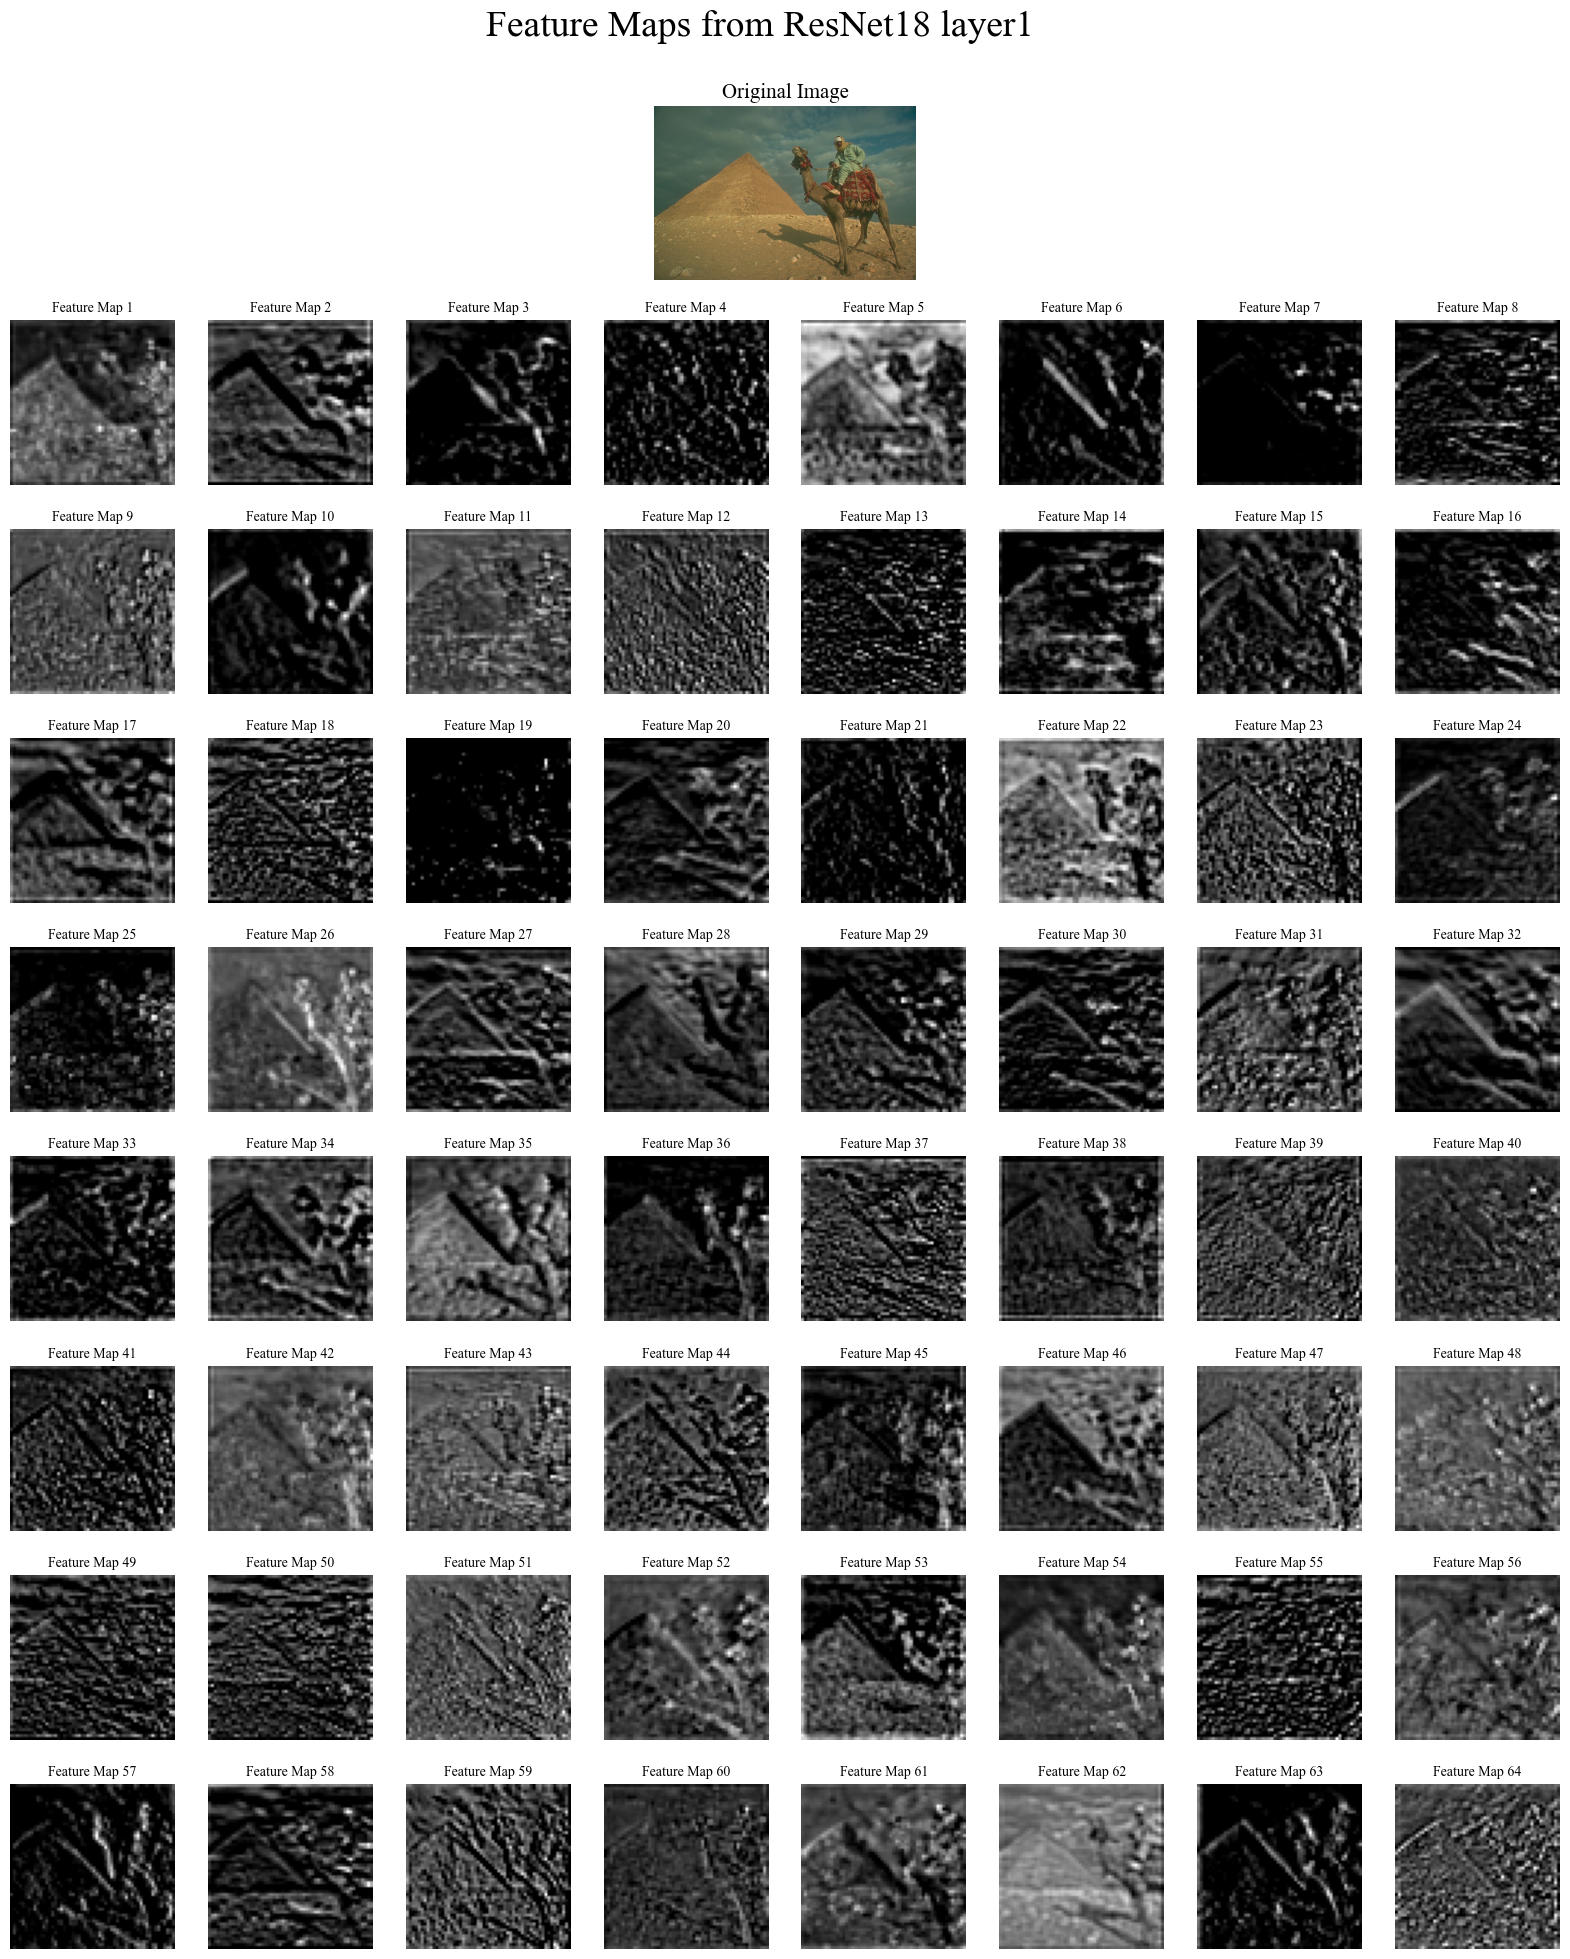

In [71]:
import os

visualize_feature_maps("../data/val_hr/" + "299086.jpg", layer_name='layer1')